# Attention Attribution

In [1]:
from dnadb import taxonomy
from itertools import cycle, repeat
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from qiime2 import Artifact
from q2_types.feature_data import TSVTaxonomyFormat
import scipy
from scipy.spatial.distance import cdist, pdist
from sklearn.manifold import MDS
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from typing import Dict

In [2]:
log_path = Path("/home/data2/deepdna/logs")

In [3]:
datasets_path = Path("/home/data2/deepdna/datasets")
reference_models = {"topdown": "Top-down"}
reference_datasets = {"silva_nr99_filtered_515f_806r": "SILVA NR99 515F/806R"}

In [4]:
def read_sample(sample):
    """
    Read a single attribution evaluation sample file in NPZ format.
    """
    sample_name = sample.with_suffix("").name
    npz = np.load(sample)
    return sample_name, npz

In [5]:
def samples_mds(samples, squeeze_batch_dim=None, mean_sample=False, exclude=[], **kwargs):
    """
    Compute the MDS of the given samples in NPZ format.
    """
    sample_names = []
    merged_embeddings = []
    for sample in samples:
        sample_name, info = read_sample(sample)
        if sample_name in exclude:
            continue
        sample_names.append(sample_name)
        embeddings = info["embeddings"]
        if squeeze_batch_dim is not None:
            embeddings = embeddings.squeeze(squeeze_batch_dim) # remove batch dimension
        merged_embeddings.append(embeddings)
    merged_embeddings = np.array(merged_embeddings)
    if mean_sample:
        merged_embeddings = np.mean(merged_embeddings, 1)
    # Compute MDS
    merged_flat = merged_embeddings.reshape((-1, merged_embeddings.shape[-1]))
    dist = cdist(merged_flat, merged_flat, metric="cityblock")
    print("Matrix size:", dist.shape)
    mds = MDS(dissimilarity="precomputed", **kwargs).fit_transform(dist)
    # Un-merge
    mds_embeddings = mds.reshape((*merged_embeddings.shape[:-1], mds.shape[-1]))
    return zip(sample_names, mds_embeddings)

In [6]:
def read_taxonomy(dataset: str, reference_model: str):
    path = datasets_path / dataset / f"taxonomy.{reference_model}.qza"
    taxa_format = Artifact.load(path).view(TSVTaxonomyFormat)
    sequence_to_taxonomy = {}
    with taxa_format.open() as f:
        f.readline()
        for line in f:
            sequence_id, label, *_ = line.strip().split('\t')
            sequence_to_taxonomy[sequence_id] = label
    return sequence_to_taxonomy

In [56]:
def attention_attribution_by_taxa_for_sample(sample_and_taxonomy_labels: tuple):
    try:
        sample, taxonomy_labels = sample_and_taxonomy_labels
        sample_name, info = read_sample(sample)
        sequence_ids = info["fasta_ids"]
        scores = info["scores"]
        scores = np.sum(scores[:,:,1:,1:], axis=(1, 2))
        taxa_abundance = {}
        taxa_scores = {}
        subsamples = len(sequence_ids)
        for ids, scores_by_id in zip(sequence_ids, scores):
            for sequence_id, score in zip(ids, scores_by_id):
                label = taxonomy_labels[sequence_id]
                if label not in taxa_scores:
                    taxa_abundance[label] = 0
                    taxa_scores[label] = 0.0
                taxa_scores[label] += score
                taxa_abundance[label] += 1
        return taxa_abundance, taxa_scores
    except Exception as e:
        print("Failed to parse:", sample)
        raise Exception()

In [57]:
def plot_taxonomy_distribution(ax, taxa_by_sample, rank, rank_names):
    rank_names = sorted(rank_names)
    total_value_by_sample = np.array([
        sum(v for v in s[rank].values() if v >= 0.0)
        for s in taxa_by_sample.values()])
    weights_by_rank = []
    for rank_name in rank_names:
        weights_by_rank.append([max(s[rank][rank_name], 0.0) for s in taxa_by_sample.values()])
    weights_by_rank = 100.0 * np.array(weights_by_rank) / total_value_by_sample
    bottom = 100.0*np.ones_like(total_value_by_sample)
    color = cycle(mpl.colormaps["tab20"].colors)
    for rank_name, weight in zip(rank_names, weights_by_rank):
        bottom -= weight
        ax.bar(list(taxa_by_sample.keys()), weight, bottom=bottom, width=0.9, label=rank_name, color=next(color))
    ax.bar(list(taxa_by_sample.keys()), bottom, width=0.9, label="Other", color="black")

## Hopland

In [151]:
outliers = ["Ur19-B-16S_S217_L001_R1_001", "Ur57-R-16S_S140_L001_R1_001"]

### MDS

In [152]:
hopland_mds_embeddings = {}
for model in tqdm(reference_models):
    path = log_path / "hopland/attribution" / model
    samples = path.glob("*.npz")
    hopland_mds_embeddings[model] = dict(samples_mds(samples, squeeze_batch_dim=1, exclude=outliers))

100%|██████████| 1/1 [00:19<00:00, 19.27s/it]


In [168]:
np.max(np.array(list(mds_embeddings.values())), axis=(0, 1))

array([59.83506871, 89.13391141])

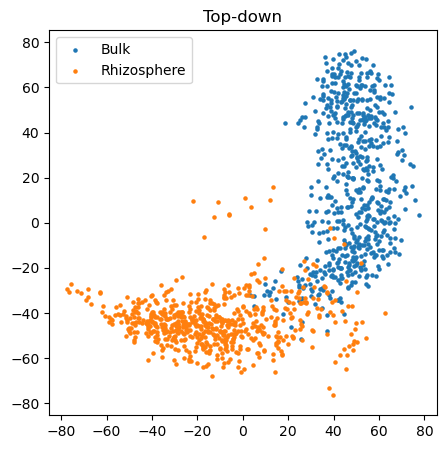

In [184]:
for model in reference_models:
    plt.figure(figsize=(5, 5))
    mds_embeddings = hopland_mds_embeddings[model]

    # find center of the plot
    axis_min = np.min(np.array(list(mds_embeddings.values())), axis=(0, 1))
    axis_max = np.max(np.array(list(mds_embeddings.values())), axis=(0, 1))
    center = (axis_max + axis_min) / 2

    # crop
    axis_max = np.max(axis_max - center)*1.1
    axis_min = np.min(axis_min - center)*1.1

    for cls, key in [("Bulk", "-B-"), ("Rhizosphere", "-R-")]:
        points = np.array([p for name, p in mds_embeddings.items() if key in name]).reshape((-1, 2))
        plt.scatter(*(points - center).T, label=cls, s=5)
    plt.title(reference_models[model])
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
    plt.legend()
    plt.show()

## SFD

In [66]:
metadata = pd.read_csv(datasets_path / "sfd/metadata.csv")
targets = {row["swab_label"]: row["oo_present"] for _, row in metadata.iterrows()}

## Precision/Recall

In [67]:
sfd_precision_recall = {}
for model in tqdm(reference_models):
    path = log_path / "sfd/attribution" / model
    samples = path.glob("*.npz")
    y_pred = []
    y_true = []
    for sample in samples:
        sample_name, info = read_sample(sample)
        target = targets[sample_name]
        y_pred += list(info["predictions"])
        y_true += [target]*len(info["predictions"])
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    sfd_precision_recall[model] = precision_recall_curve(y_true, y_pred)

100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


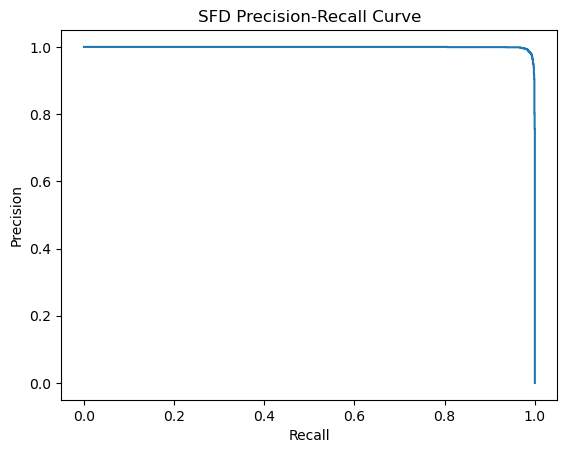

In [68]:
for model, (precision, recall, thresholds) in sfd_precision_recall.items():
    precision = np.concatenate(([0.0], precision, [1.0]), axis=0)
    recall = np.concatenate(([1.0], recall, [0.0]), axis=0)
    plt.title("SFD Precision-Recall Curve")
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")

### MDS

In [69]:
sfd_mds_embeddings = {}
n_jobs = 32
for model in tqdm(reference_models):
    path = log_path / "sfd/attribution" / model
    samples = path.glob("*.npz")
    sfd_mds_embeddings[model] = dict(samples_mds(samples, squeeze_batch_dim=1, mean_sample=True, n_jobs=n_jobs))

  0%|          | 0/1 [00:00<?, ?it/s]

Matrix size: (737, 737)


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


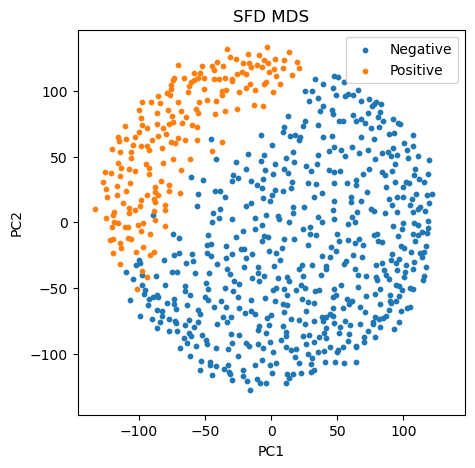

In [70]:
for model in reference_models:
    plt.figure(figsize=(5, 5))
    mds_embeddings = sfd_mds_embeddings[model]

    # find center of the plot
    axis_min = np.min(np.array(list(mds_embeddings.values())), axis=(0, 1))
    axis_max = np.max(np.array(list(mds_embeddings.values())), axis=(0, 1))
    center = (axis_max + axis_min) / 2

    # crop
    axis_max = np.max(axis_max - center)*1.1
    axis_min = np.min(axis_min - center)*1.1

    for cls, key in [("Negative", 0), ("Positive", 1)]:
        points = np.array([p for name, p in mds_embeddings.items() if targets[name] == key]).reshape((-1, 2))
        plt.scatter(*(points - center).T, label=cls, s=10)
    plt.title("SFD MDS")
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

### Attention Attribution by Taxa

In [77]:
ranks = taxonomy.RANKS[:6]
taxonomy_labels = read_taxonomy("sfd", "qiime")

In [82]:
# Compute attribution scores for each sample
sfd_attribution_by_sample = {}
for model in reference_models:
    pkl_path = log_path / "sfd" / f"attribution_by_taxonomy.{model}.qiime.pkl"
    if not pkl_path.exists():
        path = log_path / "sfd/attribution" / model
        samples = path.glob("*.npz")
        samples = [s for s in samples if s.with_suffix("").name in targets]
        sample_names = [s.with_suffix("").name for s in samples]
        attribution = {
            sample_name: dict(abundances=result[0], scores=result[1])
            for sample_name, result in zip(
                sample_names,
                process_map(
                    attention_attribution_by_taxa_for_sample,
                    zip(samples, repeat(taxonomy_labels))))
        }
        with open(pkl_path, "wb") as f:
            pickle.dump(attribution, f)
    else:
        with open(pkl_path, "rb") as f:
            attribution = pickle.load(f)
    sfd_attribution_by_sample[model] = attribution

In [83]:
# Aggregate across class type
sfd_attribution_by_class = {}
for model in reference_models:
    result = {cls: {"abundances": {}, "scores": {}} for cls in ("Positive", "Negative")}
    for sample_name, attribution in sfd_attribution_by_sample[model].items():
        cls = "Positive" if targets[sample_name] == 1 else "Negative"
        m = 1 if cls == "Positive" else -1
        for label in attribution["scores"]:
            if label not in result[cls]["scores"]:
                result[cls]["abundances"][label] = 0
                result[cls]["scores"][label] = 0.0
            result[cls]["abundances"][label] += attribution["abundances"][label]
            result[cls]["scores"][label] += m*attribution["scores"][label]
    sfd_attribution_by_class[model] = result

In [84]:
# Aggregate across all samples
sfd_attribution = {}
for model in reference_models:
    result = {"abundances": {}, "scores": {}}
    for sample_name, attribution in sfd_attribution_by_sample[model].items():
        for label in attribution["scores"]:
            if label not in result["scores"]:
                result["abundances"][label] = 0
                result["scores"][label] = 0.0
            result["abundances"][label] += attribution["abundances"][label]
            result["scores"][label] += attribution["scores"][label]
    sfd_attribution[model] = result

In [85]:
sfd_attribution_tables = {}
for model, attribution in sfd_attribution.items():
    rows = []
    for label in sorted(attribution["scores"], key=lambda x: attribution["scores"][x], reverse=True):
        rows.append([*taxonomy.split_taxonomy(label), attribution["abundances"][label], attribution["scores"][label]])
    sfd_attribution_tables[model] = pd.DataFrame(data=rows, columns=[*ranks, "Abundance", "Score"])
sfd_attribution_tables["topdown"]

,Domain,Phylum,Class,Order,Family,Genus,Abundance,Score
0,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Stenotrophomonas,124455,7358.458789
1,Bacteria,Synergistota,Synergistia,Synergistales,Synergistaceae,Jonquetella,52638,6208.987179
2,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,64240,2443.871294
3,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,69795,2340.444591
4,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,21164,1426.482950
...,...,...,...,...,...,...,...,...
1876,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,231319,-9578.842260
1877,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,155983,-10307.751739
1878,Bacteria,Actinobacteriota,Actinobacteria,Propionibacteriales,Nocardioidaceae,Nocardioides,225297,-11458.707503
1879,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Dermacoccaceae,Dermacoccaceae,117554,-11500.076039


In [86]:
sfd_attribution_by_class_tables = {}
for model, attribution_by_class in sfd_attribution_by_class.items():
    sfd_attribution_by_class_tables[model] = {}
    for cls, attribution in attribution_by_class.items():
        rows = []
        for label in sorted(attribution["scores"], key=lambda x: attribution["scores"][x], reverse=True):
            rows.append([*taxonomy.split_taxonomy(label), attribution["abundances"][label], attribution["scores"][label]])
        sfd_attribution_by_class_tables[model][cls] = pd.DataFrame(data=rows, columns=[*ranks, "Abundance", "Score"])

In [87]:
sfd_attribution_by_class_tables["topdown"]["Positive"]

,Domain,Phylum,Class,Order,Family,Genus,Abundance,Score
0,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Stenotrophomonas,39848,1410.537566
1,Bacteria,Synergistota,Synergistia,Synergistales,Synergistaceae,Jonquetella,6307,807.965136
2,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,10564,516.068406
3,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Cytophagaceae,Siphonobacter,15642,296.406178
4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,11288,284.390588
...,...,...,...,...,...,...,...,...
1710,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Dietziaceae,Dietzia,19963,-1208.398393
1711,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelotrichaceae,[Clostridium]_innocuum_group,14969,-1227.351761
1712,Bacteria,Actinobacteriota,Actinobacteria,Propionibacteriales,Nocardioidaceae,Nocardioides,59116,-1327.749304
1713,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,45708,-1611.986009


In [88]:
sfd_attribution_by_class_tables["topdown"]["Negative"]

,Domain,Phylum,Class,Order,Family,Genus,Abundance,Score
0,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Dermacoccaceae,Dermacoccaceae,94768,11229.511218
1,Bacteria,Actinobacteriota,Actinobacteria,Propionibacteriales,Nocardioidaceae,Nocardioides,166181,10130.958199
2,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,121936,9387.886962
3,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,185611,7966.856251
4,Bacteria,Actinobacteriota,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,73720,6770.335268
...,...,...,...,...,...,...,...,...
1849,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,15872,-1145.898383
1850,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,53676,-1927.802888
1851,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,57905,-2290.630610
1852,Bacteria,Synergistota,Synergistia,Synergistales,Synergistaceae,Jonquetella,46331,-5401.022043


In [89]:
def aggregate_attribution_table_by_rank(table, rank):
    ranks = taxonomy.RANKS[:taxonomy.RANKS.index(rank) + 1]
    result = {}
    for _, row in table.iterrows():
        label = tuple(row[r] for r in ranks)
        if label not in result:
            result[label] = {"abundance": 0, "score": 0.0}
        result[label]["abundance"] += row["Abundance"]
        result[label]["score"] += row["Score"]
    rows = []
    for label, values in result.items():
        rows.append([*label, values["abundance"], values["score"]])
    rows.sort(key=lambda x: x[-1], reverse=True)
    return pd.DataFrame(rows, columns=[*ranks, "Abundance", "Score"])

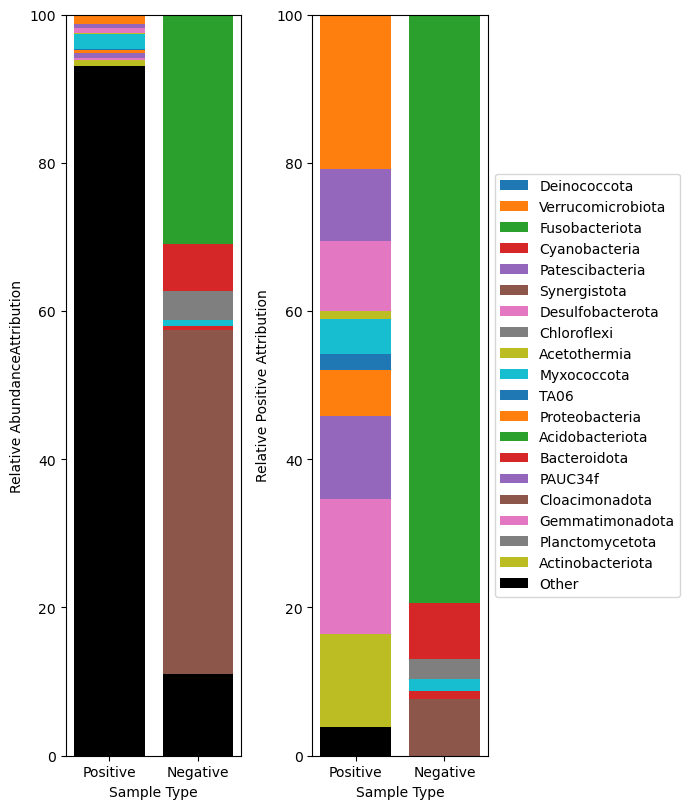

In [90]:
def taxonomic_bar_plot_from_attribution(abundance_ax, score_ax, attribution_tables_by_class, rank="Phylum", top_k=10):
    top_taxa = set()
    tables_by_class = {}
    abundance_by_class = {}
    score_by_class = {}
    for cls, attribution_table in attribution_tables_by_class.items():
        # Aggregate the table and store top k
        df = aggregate_attribution_table_by_rank(attribution_table, rank)
        tables_by_class[cls] = df.head(top_k)

        # Compute the total abundance and score
        total_abundance = sum(v for v in df["Abundance"])
        total_score = sum(v for v in df["Score"] if v >= 0.0)

        # Compute the
        abundance_by_class[cls] = {}
        score_by_class[cls] = {}
        for _, row in tables_by_class[cls].iterrows():
            # top_taxa.update(list(tables_by_class[cls][rank]))
            abundance_by_class[cls][row["Phylum"]] = 100.0*row["Abundance"]/total_abundance
            score_by_class[cls][row["Phylum"]] = 100.0*row["Score"]/total_score
            top_taxa.add(row["Phylum"])

    abundance_weights = []
    score_weights = []
    for tax in sorted(top_taxa):
        abundance_weights.append([])
        score_weights.append([])
        for cls in abundance_by_class:
            abundance_weights[-1].append(abundance_by_class[cls].get(tax, 0))
            score_weights[-1].append(score_by_class[cls].get(tax, 0.0))
    abundance_weights = np.array(abundance_weights)
    score_weights = np.array(score_weights)

    bottom_abundance = 100.0*np.ones(len(abundance_by_class))
    bottom_score = 100.0*np.ones(len(score_by_class))

    for tax, abundance, score in zip(top_taxa, abundance_weights, score_weights):
        bottom_abundance -= abundance
        bottom_score -= score
        abundance_ax.bar(list(tables_by_class.keys()), abundance, bottom=bottom_abundance, label=tax)
        score_ax.bar(list(tables_by_class.keys()), score, bottom=bottom_score, label=tax)
    abundance_ax.bar(list(tables_by_class.keys()), bottom_abundance, color="black", label="Other")
    score_ax.bar(list(tables_by_class.keys()), bottom_score, color="black", label="Other")

    for ax in (abundance_ax, score_ax):
        ax.set_ylim([0, 100.0])


for model, attributions_by_class in sfd_attribution_by_class_tables.items():
    fig, axs = plt.subplots(1, 2, figsize=(7, 8.2))
    taxonomic_bar_plot_from_attribution(*axs, attributions_by_class)
    axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5, 0.0, 0.0))
    axs[0].set_xlabel("Sample Type")
    axs[1].set_xlabel("Sample Type")
    axs[0].set_ylabel("Relative AbundanceAttribution")
    axs[1].set_ylabel("Relative Positive Attribution")
    plt.tight_layout()

In [91]:
sfd_attribution_by_class_tables["topdown"]["Positive"].head(10)

,Domain,Phylum,Class,Order,Family,Genus,Abundance,Score
0,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Stenotrophomonas,39848,1410.537566
1,Bacteria,Synergistota,Synergistia,Synergistales,Synergistaceae,Jonquetella,6307,807.965136
2,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,10564,516.068406
3,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Cytophagaceae,Siphonobacter,15642,296.406178
4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,11288,284.390588
5,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,5292,280.584567
6,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Dermabacteraceae,Brachybacterium,7084,267.349346
7,Bacteria,Acidobacteriota,Blastocatellia,Blastocatellales,Blastocatellaceae,Blastocatella,6539,267.307015
8,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,3827,255.767383
9,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,10224,247.071392


In [ ]:
plt.figure(figsize=(7, 8.2))
plt.suptitle("Relative Abundance & Positive Attribution Comparison")

plt.subplot(121)
topk = 10
rank = "Phylum"
rank_names = set()
for s in scores_by_type.values():
    rank_names |= set(list(s[rank].keys())[:topk])

plot_taxonomy_distribution(plt, abundance_by_type, rank, rank_names)
plt.xticks(list(abundance_by_type.keys()), rotation=50)
plt.ylim([0, 100.0])
plt.xlabel("Sample Type")
plt.ylabel("Relative Abundance")
plt.tight_layout()

plt.subplot(122)
plot_taxonomy_distribution(plt, scores_by_type, rank, rank_names)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5, 0.0, 0.0))
plt.xticks(list(scores_by_type.keys()), rotation=50)
plt.ylim([0, 100.0])
plt.xlabel("Sample Type")
plt.ylabel("Relative Positive Attribution")
plt.tight_layout()
plt.show()